In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df = pd.read_excel('ibm dow final.xlsx')

In [3]:
# check that date is not an object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    253 non-null    datetime64[ns]
 1   ibm     253 non-null    float64       
 2   dow     253 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 6.1 KB


In [4]:
# as a precaution, making it so (prior problems importing datetime from excel)
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    253 non-null    datetime64[ns]
 1   ibm     253 non-null    float64       
 2   dow     253 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 6.1 KB


In [6]:
print(df)

          Date     ibm       dow
0   2023-10-31  144.64  33052.87
1   2023-11-01  145.40  33274.58
2   2023-11-02  147.01  33839.08
3   2023-11-03  147.90  34061.32
4   2023-11-06  148.97  34095.86
..         ...     ...       ...
248 2024-10-25  214.67  42114.40
249 2024-10-28  212.91  42387.57
250 2024-10-29  210.43  42233.05
251 2024-10-30  204.90  42141.54
252 2024-10-31  206.72  41763.46

[253 rows x 3 columns]


In [7]:
# again, precaution from importing from excel
df = df.sort_values(by=['Date'])

In [8]:
print(df)

          Date     ibm       dow
0   2023-10-31  144.64  33052.87
1   2023-11-01  145.40  33274.58
2   2023-11-02  147.01  33839.08
3   2023-11-03  147.90  34061.32
4   2023-11-06  148.97  34095.86
..         ...     ...       ...
248 2024-10-25  214.67  42114.40
249 2024-10-28  212.91  42387.57
250 2024-10-29  210.43  42233.05
251 2024-10-30  204.90  42141.54
252 2024-10-31  206.72  41763.46

[253 rows x 3 columns]


In [9]:
df = df.set_index('Date')

In [10]:
base = '2023-10-31'
base_value = df.loc[base]

In [11]:
# indexing variables; vaules on 2023-10-31 = 100
df['ibm_index'] = (df['ibm'] / base_value['ibm']) * 100
df['dow_index'] = (df['dow'] / base_value['dow']) * 100

<Figure size 1200x600 with 0 Axes>

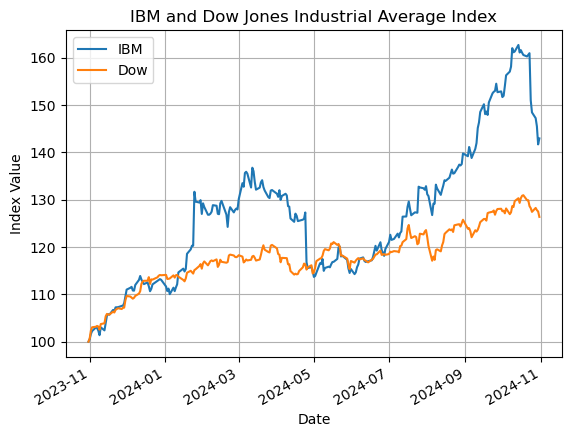

In [12]:
# looks as though ibm periodically beat dow jones?
plt.figure(figsize=(12, 6))
df[['ibm_index', 'dow_index']].plot()
plt.title('IBM and Dow Jones Industrial Average Index')
plt.legend(['IBM', 'Dow'])
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Index Value')
   
plt.show()

In [13]:
# finding period to period change
df['ibm_return'] = df['ibm'].pct_change()
df['ibm_return'] = df['ibm_return'].dropna()
df['dow_return'] = df['dow'].pct_change()
df['dow_return'] = df['dow_return'].dropna()

In [14]:
print(df['ibm_return'])

Date
2023-10-31         NaN
2023-11-01    0.005254
2023-11-02    0.011073
2023-11-03    0.006054
2023-11-06    0.007235
                ...   
2024-10-25   -0.017034
2024-10-28   -0.008199
2024-10-29   -0.011648
2024-10-30   -0.026280
2024-10-31    0.008882
Name: ibm_return, Length: 253, dtype: float64


In [15]:
df['excess_return'] = (df['ibm_return'] - df['dow_return'])

In [16]:
# checking new vars have been added to dataframe
print(df)

               ibm       dow   ibm_index   dow_index  ibm_return  dow_return  \
Date                                                                           
2023-10-31  144.64  33052.87  100.000000  100.000000         NaN         NaN   
2023-11-01  145.40  33274.58  100.525442  100.670774    0.005254    0.006708   
2023-11-02  147.01  33839.08  101.638551  102.378644    0.011073    0.016965   
2023-11-03  147.90  34061.32  102.253872  103.051021    0.006054    0.006568   
2023-11-06  148.97  34095.86  102.993639  103.155520    0.007235    0.001014   
...            ...       ...         ...         ...         ...         ...   
2024-10-25  214.67  42114.40  148.416759  127.415259   -0.017034   -0.006135   
2024-10-28  212.91  42387.57  147.199945  128.241723   -0.008199    0.006486   
2024-10-29  210.43  42233.05  145.485343  127.774230   -0.011648   -0.003645   
2024-10-30  204.90  42141.54  141.662058  127.497370   -0.026280   -0.002167   
2024-10-31  206.72  41763.46  142.920354

<Figure size 1200x600 with 0 Axes>

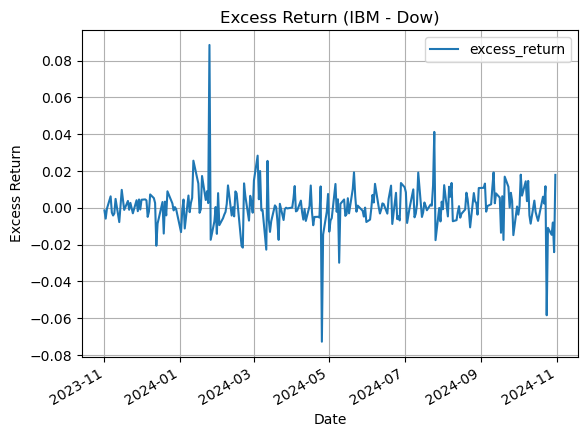

In [17]:
# now returns look more muted
plt.figure(figsize=(12, 6))
df[['excess_return']].plot()
plt.title('Excess Return (IBM - Dow)')
plt.legend(['excess_return'])
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Excess Return')
   
plt.show()

In [18]:
df['lagged_excess_return'] = df['excess_return'].shift(1)

In [19]:
# Autoregressive model for 1 period
# just ols where independent is the same as dependant 
def run_ar1_reg(df):
    excess_return = df['excess_return'].copy()
    df['lagged_excess_return'] = df['excess_return'].shift(1)
    regression_df = pd.DataFrame({
    'excess_return':df['excess_return'],
    'lagged_excess_return':df['lagged_excess_return']
    }).dropna()
    regression_df = regression_df.dropna()
    x = sm.add_constant(regression_df['lagged_excess_return'])
    y = regression_df['excess_return']
    model = sm.OLS(y, x)
    model_fit=model.fit()

    return model_fit

In [20]:
# historic stock performance has no significant influence on present stock value
# at least for 1 period
# therefore, fail to reject efficent market hypothesis
regression_result = run_ar1_reg(df)
print(regression_result.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.01474
Date:                Mon, 03 Feb 2025   Prob (F-statistic):              0.903
Time:                        21:23:08   Log-Likelihood:                 748.44
No. Observations:                 251   AIC:                            -1493.
Df Residuals:                     249   BIC:                            -1486.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0006 